## Tutorial 3: Poisson Equation (Advanced)

In this tutorial, we will try to validate an advanced implementation of the problem described by the previous tutorial, which should be looked at first. The main objective is to check some properties of iterative methods applied to the Poisson problem, specifically those described in the chapter 4.2 of $\mathrm{LeVeque^{[1]}}$.

$\mathrm{^{[1]}}$ __LeVeque, R.J., 2007. Finite difference methods for ordinary and partial differential equations: steady-state and time-dependent problems (Vol. 98). Siam.__ 

The spectral radius $\rho$ of the iteration matrix is a value that measures how much the error decays after one iteration for the worst scenario, which happens for the lowest frequencies of the solution. Given an initial error at the nth step $e^{[n]}$, the error after one iteration $e^{[n + 1]}$ is bounded by $\rho\ e^{[n]}$. From section 4.2 of the book "Finite Difference Methods for Ordinary and Partial Differential Equations", we can get the formula of the spectral radius $\rho$ in the case of some common implicit methods:

$$\textrm{Jacobi:}\ \rho_h = \cos{(\pi h)} = 1 - \frac{\pi^2 h^2}{2} + O(h^4)$$

$$\textrm{Gauss-Seidel:}\ \rho_h = 1 - \pi^2 h^2 + O(h^4)$$

$$\textrm{SOR using}\ \omega_{opt} = \frac{2}{1 + \sin{(\pi h)}}\textrm{:}\ \rho_h = 1 - 2 \pi h + O(h^2)$$

Since $e^{[n + 1]} = \rho\ e^{[n]}$, given an error reduction factor $\epsilon$ such that we want $e^{[n]} \leq \epsilon\ e^{[0]}$, then the required number of iterations $k$ to guarantee that precision respects the equation:

$$\rho^k \leq \epsilon \implies k \geq \log_{\rho} \epsilon = \frac{\log \epsilon}{\log \rho}$$

In [1]:
from devito import Grid
from math import log, ceil, cos, pi

shape = (50, 50)   # Grid size in number of points
extent = (1., 1.)  # Grid domain limits -> [0,1] x [0,1]

epsilon = 0.1
space_order = 2

grid = Grid(shape = shape, extent = extent) # The spatial grid
hx, hy = grid.spacing # The calculated spatial steps (dx and dy)

assert abs(hx - hy) < 0.0001, \
    "Spatial spacing must be equal in both dimensions for analysis (%e, %e)" % (hx, hy)

h = hx # This could be h = hy or h = (hx + hy) / 2


rho = cos(pi * h) # The spectral radius of the iterative matrix
k = ceil(log(epsilon, rho)) # The required number of iterations

print("Grid spacing is %f" % h)
print("Spectral radius of the iteration matrix is %f for the Jacobi method" % rho)
print("Number of iterations to guarantee precision for the worst frequence is %d" % k)

Grid spacing is 0.020408
Spectral radius of the iteration matrix is 0.997945 for the Jacobi method
Number of iterations to guarantee precision for the worst frequence is 1120


One of the main disadvantages of using the Jacobi method is that is has very slow convergence rate for the lowest frequency of the solution. For the problem above $\rho \approx 0.998$, which means that the upper bound for the error decreases by only 0.2% every iteration.

Also note that, some of the time, depending on the initial guess, the number of iterations executed is not enough to guarantee the precision. A very common residual criteria is to stop whenever the relative error is below a limit $\epsilon$:

$$\mathrm{stop\ if\ } \frac{||p_{n+1}-p_n||_2}{||p_n||_2} < \epsilon$$.

But if that condition is used, there is no guarantee that the number $k$ of required iterations will be executed. This relation depends on the value of the condition number $\kappa_2$ of the eigenvector matrix using norm-2, presented in the section 4.2.1 of LeVeque. This value measures how the evolution of the residual compares with the evolution of the error.

Let's now build an Operator that will solve the same problem as the last tutorial, but being able to choose between Jacobi, Gauss-Seidel or SOR and using the relative residual as the stop condition, instead of the absolute one. Let's also not save all the iterations, but use alternating buffers to save memory, so that we can vary $h$ into a wider range, without having to use swap memory. Let's also enable parallelism with OpenMP and enable aggressive optimizations to make our tests run faster.

In [2]:
from devito import configuration

configuration['loop-splitting'] = False
configuration['language'] = 'openmp'

In [3]:
# Choose your method
#method = 'jacobi'
#method = 'gauss'
method = 'sor'

In [4]:
from devito import Dimension, ConditionalDimension, Eq, Function, Inc, Operator, TimeFunction, solve
from numpy import int32
from sympy import sin as Sin

# The symbolic representation of the Poisson function
p = TimeFunction(name = 'p', grid = grid, space_order = space_order)

# The symbolic representation of the Poisson source/forcing term
f = Function(name = 'f', grid = grid, space_order = space_order)

# The symbolic representation of the absolute residual ||p(n + Δn) - p(n)||
residual = Function(name = 'residual', shape = (1,), dimensions = (Dimension(name = 'residual_dim'),))

# The symbolic representation of the normalizing term ||p(n + Δn)||
pnorm = Function(name = 'pnorm', shape = (1,), dimensions = (Dimension(name = 'pnorm_dim'),))

# The variable that will store which iteration is currently being executed
niter = Function(name = 'niter', shape = (1,), dimensions = (Dimension(name = 'niter_dim'),),
                 dtype = int32)

n = grid.stepping_dim  # The dimension of iteration
x, y = grid.dimensions # The spatial dimensions

# Temporary dimensions used to separate the residual calculation from the PDE equation
# Note: Since we use a Dimension instead of DefaultDimension, then we have to later set
#       xt_M and yt_M manually when calling the operator
xtemp = Dimension(name = 'xt')
ytemp = Dimension(name = 'yt')

xy_to_xtyt = [(x, xtemp), (y, ytemp)] # Used to convert an equation written in (x,y) to (xtemp, ytemp)

# Epsilon is now a variable so that it can be dynamically changed
epsilon = Function(name = 'epsilon', shape = (1,), dimensions = (Dimension(name = 'epsilon_dim'),))

cn = ConditionalDimension(name = 'cn', parent = n.parent,
                          condition = (residual[0] >= pnorm[0] * epsilon[0]), brk = True)

# The poisson PDE
pde = Eq(p.laplace, f, subdomain = grid.interior)

# One iteration of the Jacobi method
jacobiEq = solve(pde, p)

# One iteration of the Gauss-Seidel method
# Note: Gauss-Seidel equation is the same as the Jacobi one, but changing p(n) to p(n + Δn),
#       thus forcing one iteration to operate using only p(n + Δn), which is a single array
gaussEq = jacobiEq.subs(n, n + n.spacing)

if method == 'jacobi':
    iterEq = Eq(p.forward, jacobiEq)
elif method == 'gauss':
    iterEq = Eq(p.forward, gaussEq)
elif method == 'sor':
    # This is the equation for the optimal omega
    #omega = 2 / (1 + pi * Sin(grid.spacing_symbols[0])) # Exact omega
    omega = 2 - 2 * pi * grid.spacing_symbols[0] # Approximated omega

    # One iteration of the SOR method
    sorEq = omega * gaussEq + (1 - omega) * p.forward

    iterEq = Eq(p.forward, sorEq)

# Equation to calculate ||p(n + Δn) - p(n)||
resEq = [Eq(residual[0], 0, implicit_dims = [n]),
         Inc(residual[0], (p.forward - p).subs(xy_to_xtyt) ** 2)]

# Equation to calculate ||p(n + Δn)||
pnormEq = [Eq(pnorm[0], 0, implicit_dims = [n]),
           Inc(pnorm[0], p.subs(xy_to_xtyt) ** 2)]

# Equation to count, so we can know in what iteration it stopped
cntEq = Eq(niter[0], cn)

# Dirichlet boundary conditions
boundary = [Eq(p[n + 1, 0, y], 0.)]
boundary += [Eq(p[n + 1, x.symbolic_max, y], 0.)]
boundary += [Eq(p[n + 1, x, 0], 0.)]
boundary += [Eq(p[n + 1, x, y.symbolic_max], 0.)]

if method == 'jacobi':
    eqs = [iterEq] + boundary + resEq + pnormEq + [cntEq]
else:
    # Save last iteration so we can calculate the residual
    saveEq = Eq(p.forward, p)

    eqs = [saveEq, iterEq] + boundary + resEq + pnormEq + [cntEq]

op = Operator(eqs)

To validate the execution of the developed implicit method, we will execute it using various values for the spatial step $h = h_x = h_y$. This will be done to check the approximately linear evolution of the relative error ratio $r_h$ when reducing the value of the spatial step $h$ linearly, for low values of $h \rightarrow 0$.

Here is a demonstration for the two properties using the Gauss-Seidel spectral radius. The demonstration is almost identical for the Jacobi and SOR, the latter having a decay of $\alpha$ instead of $\alpha^2$:

$$r_h = \frac{e^{[n + 1]} - e^{[n]}}{e^{[n]}} = \rho - 1 \approx - \pi^2 h^2\ \textrm{when}\ h \rightarrow 0 \implies \frac{r_h}{r_{\frac{h}{\alpha}}} \approx \frac{- \pi^2 h^2}{-\pi^2 (\frac{h}{\alpha})^2} = \alpha^2 \implies r_{\frac{h}{\alpha}} \approx \frac{r_h}{\alpha^2} \implies$$

$$ \implies  \textrm{The relative error when dividing the spacing by a factor}\ \alpha \textrm{ decays by a factor of } \alpha^2$$

$$k_h = \frac{\log \epsilon}{\log \rho_h} \implies \frac{k_{\frac{h}{\alpha}}}{k_h} = \frac{\log (\rho_h)}{\log (\rho_{\frac{h}{\alpha}})} \approx \frac{\log (1 - \pi^2 h^2)}{\log (1 - \pi^2 (\frac{h}{\alpha})^2)} \approx \frac{- \pi^2 h^2}{-\pi^2 (\frac{h}{\alpha})^2} = \alpha^2 \implies k_{\frac{h}{\alpha}} \approx k_h \alpha^2 \implies$$

$$ \implies \textrm{The number of required iterations increases approximately by } \alpha^2 \textrm{ when the number of points increases by a factor of}\ \alpha$$

__Note__: The taylor expansion for $\log (1 - h)$ around $h = 0$ is $\log (1 - h) = -h - \frac{h^2}{2} - \frac{h^3}{3} - O(h^4)$

In [5]:
# If "exec_all" is true, then execute exactly n% of the required k iterations
if method == 'sor':
    exec_all = True
else:
    exec_all = False
npercent = 1

epsilon_ = 0.0000001
nmax = 10000 # This is the maximum iterations when exec_all = False

In [6]:
from warnings import warn

msg = "This cell usually takes minutes to properly execute. Try reducing 'ns' for a faster execution."
warn(msg, RuntimeWarning)

from numpy import cos, inf, round, linspace, meshgrid, sin
from numpy.linalg import norm

# Useful: h[i] = extent[i] / (shape[i] - 1) => shape[i] = extent[i] / h[i] + 1

extent = 1.0

# Test parameters
h0 = 0.25 # First spatial step
alpha = 2 # Linear factor to decrease h
ns = 8    # Number of spacings to be calculated

H = [h0 * alpha ** -i for i in range(ns)]                   # List of spacings to be tested
shapes = [int(round(extent / H[i]) + 1) for i in range(ns)] # List of shapes for the grid

if exec_all:
    epsilon.data[0] = 0.0
else:
    epsilon.data[0] = epsilon_

hs = []     # List of actual spacings used
niters = [] # List of performed iterations
rs = []     # List of relative errors
ks = []     # List of required number of iterations

# Auxiliary function to calculate the absolute error in an iteration
def absolute_error(p, it, sol):
    return norm(sol - p.data[it, :, :], ord = 2)

extent = (extent, extent)
for shape in shapes:
    shape = (shape, shape)
    grid = Grid(shape = shape, extent = extent)
    h = grid.spacing[0]

    pnorm.data[0] = 0
    residual.data[0] = 0
    niter.data[0] = 0

    p = TimeFunction(name = 'p', grid = grid, space_order = space_order)
    p.data[:] = 0 # Initial data is null instead of random for consistent results if executing more than once

    residuals = Function(name = 'residuals', shape = grid.shape, dimensions = [xtemp, ytemp], space_order = space_order)

    f = Function(name = 'f', grid = grid)
    H = linspace(0., 1., shape[0], endpoint = True)
    X, Y = meshgrid(H, H, sparse = True)

    f.data[:] = 4 * pi ** 2 * sin(2 * pi * X) * (2 * cos(2 * pi * Y) - 1)
    solution = sin(2 * pi * X) * (1 - cos(2 * pi * Y))

    if method == "jacobi":
        rho = 1 - pi ** 2 * h ** 2 / 2
    elif method == "gauss":
        rho = 1 - pi ** 2 * h ** 2
    elif method == "sor":
        rho = 1 - 2 * pi * h
    if rho < 0:
        rho = epsilon_
    k = ceil(log(epsilon_) / log(rho))

    if exec_all:
        nmax = ceil(k * npercent)

    # Note: h_x and h_y must be manually updated since they are present in the equations of the operator
    op(time_M = nmax, p = p, f = f, h_x = h, h_y = h, xt_M = p.shape[1] - 1, yt_M = p.shape[2] - 1)
    last_iter = niter.data[0]

    En = absolute_error(p, last_iter - 1, solution)
    rh = abs(absolute_error(p, last_iter, solution) - En) / En

    hs.append(h)
    niters.append(last_iter)
    rs.append(rh)
    ks.append(k)

<ipython-input-6-ad7f82d9663b>:4: RuntimeWarning: This cell usually takes minutes to properly execute. Try reducing 'ns' for a faster execution.
  warn(msg, RuntimeWarning)
Operator `Kernel` ran in 0.08 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.07 s
Operator `Kernel` ran in 0.41 s
Operator `Kernel` ran in 3.81 s
Operator `Kernel` ran in 29.79 s


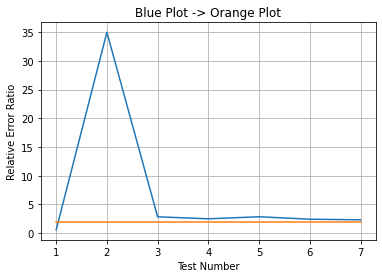

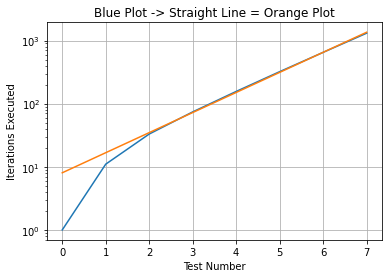

In [7]:
from numpy import array, exp, full, log, polyfit
import matplotlib.pyplot as plt

# Cast some of the lists to numpy array
rs = array(rs)
niters = array(niters)

ratios = rs[:-1] / rs[1:]

# Plot the relative error ratio
# Note: This plot should approach "alpha ** 2" for Jacobi and Gauss-Seidel and "alpha" for SOR
plt.figure()
plt.title("Blue Plot -> Orange Plot")
plt.grid()
plt.xlabel("Test Number")
plt.ylabel("Relative Error Ratio")
X = range(1, ns)
plt.xticks(X)
plt.plot(X, ratios)
if method == 'sor':
    plt.plot(X, full(ns-1, alpha))
else:
    plt.plot(X, full(ns-1, alpha ** 2))

# Plot the number of required iterations
# Note: This plot should be approximately line (when exec_all = False), especially for smaller h
plt.figure()
plt.title("Blue Plot -> Straight Line = Orange Plot")
plt.grid()
plt.xlabel("Test Number")
plt.ylabel("Iterations Executed")
plt.yscale('log')
X = range(ns)
plt.xticks(X)
plt.plot(X, niters)
a, b = polyfit(X[2:], log(niters[2:]), 1)
plt.plot(X, exp(a * X + b))

None

If you try to plot the last approximated solution, even though the basic "form" of the solution already shows up, you will see that it is not even close to the real solution, especially for the Jacobi and Gauss-Seidel methods. That happens because, as $h \rightarrow 0$, the number of iterations required for the method to converge increases by the order of $h^2$. This means that when $h = 0.001$, for example, the number of required iterations to guarantee precision is on the order of $\frac{1}{h^2} = 10^6$. The convergence is very slow in this case, so $10^6$ is much higher than the actual number of iterations executed when using the relative error stop criteria.

Even though the real solution is still very badly approximated for small $h$, the properties deduced in this notebook are independent of the current iteration index and also independent of the actual distance between the real and approximated solution.

In [8]:
from numpy import max, min

if method != "sor":
    print("The absolute error of the last approximated solution is %f, which is still very large\n" % En)
    print("The maximum and minimum value for the last approximated solution are %f and %f." % (max(p.data[0,:]),
                                                                                              min(p.data[0,:])))
    print("These values should converge to ±2, but are still far away\n")
    
    print("Even though %d iterations should be done for guaranteed convergence, only %d were executed" % (ks[-1],
                                                                                                      niter.data[0]))

__Warning__: Be aware that we are plotting large data when using the code below, which will be the last approximated solution with the smallest $h$. As you can see, the solution has the basic "form", but the actual values are still far from the real solution.